In [17]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.82 ms


In [164]:
%pylab inline
from snakebite.client import Client
import pyaml as yaml
import sys
import pythonrun
reload(pythonrun)
import os
import seaborn as sns
from sklearn import metrics
import scala_python_endive_wrapper
reload(scala_python_endive_wrapper)
from scala_python_endive_wrapper import *
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib
time: 19.8 ms


In [4]:
hdfsclient = Client("amp-spark-master.amp", 8020, use_trash=False)
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')
logpath = "/tmp/log"

time: 7.85 ms


In [135]:
def pr_result(y_train, y_test, y_train_pred, y_test_pred):
    fpr, tpr, thresh = metrics.precision_recall_curve(y_train, y_train_pred)
    train_auc = metrics.average_precision_score(y_train, y_train_pred)
    plot(fpr, tpr, label="train")
    fpr, tpr, thresh = metrics.precision_recall_curve(y_test, y_test_pred)
    test_auc = metrics.average_precision_score(y_test, y_test_pred)
    plot(fpr, tpr, label="test")
    plt.legend(loc=4)
    plt.figure()
    print("Train PR AUC {0}".format(train_auc))
    print("Test PR AUC {0}".format(test_auc))
    
def roc_result(y_train, y_test, y_train_pred, y_test_pred):
    fpr, tpr, thresh = metrics.roc_curve(y_train, y_train_pred)
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    plot(fpr, tpr, label="train")
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    plot(fpr, tpr, label="test")
    plt.legend(loc=4)
    plt.figure()
    print("Train ROC AUC {0}".format(train_auc))
    print("Test ROC AUC {0}".format(test_auc))

time: 29 ms


In [5]:

executor_mem = "200g"
cores_per_executor = 24
num_executors = 14

time: 2.75 ms


In [9]:
# CHANGE ME
dataset_creation_config = \
{
    "labels": "/user/vaishaal/endive-data/ChIPseq/labels/EGR1.train.labels.tsv", \
    "reference": "/home/eecs/akmorrow/ADAM/endive/workfiles/hg19.2bit", \
    "dnase": "/user/vaishaal/endive-data/DNASE/peaks/relaxed/", \
    "aggregatedSequenceOutput": "/user/vaishaal/endive-data/aggregated/EGR1/"
}

EGR1_PATH = "/user/vaishaal/endive-data/aggregated/EGR1/EGR1"


time: 3.97 ms


In [142]:
# this is where the magic happens
results = [] 
for seed in range(2):
        res = run_kitchensink_featurize_pipeline(EGR1_PATH,
                           "/tmp/filters.csv", 
                           logpath, 
                           seed=0,
                           filter_gen_gen=make_gaussian_filter_gen,
                           cores_per_executor=cores_per_executor,
                           sample=0.001,
                           executor_mem=executor_mem,
                           featuresOutput="/user/vaishaal/tmp/featurizedWindows/tiny/replicate-{0}/".format(seed),
                           num_executors=num_executors)
        results.append(res)
 
        
  

(256, 32)
(256, 32)
time: 5min 9s


In [174]:
res = run_solver_pipeline("/user/vaishaal/tmp/featurizedWindows/tiny/replicate-0",
                           logpath, 
                           hdfsclient,
                           executor_mem=executor_mem,
                           num_executors=num_executors,
                           valCellTypes=[8],
                           valChromosomes=["chr10"],
                           valDuringSolve=True)


/user/vaishaal/tmp/valPreds_chr11_8

time: 52.1 s


In [172]:
test_preds = run_test_pipeline("/user/vaishaal/tmp/featurizedWindows/tiny/replicate-1",
                                logpath, 
                                hdfsclient)


time: 34 s


#### ROC Metrics

Train PR AUC 0.0986490822579
Test PR AUC 0.0893466132806
Train ROC AUC 0.884089628045
Test ROC AUC 0.863655048408


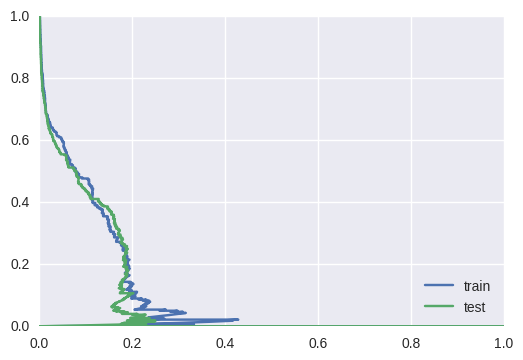

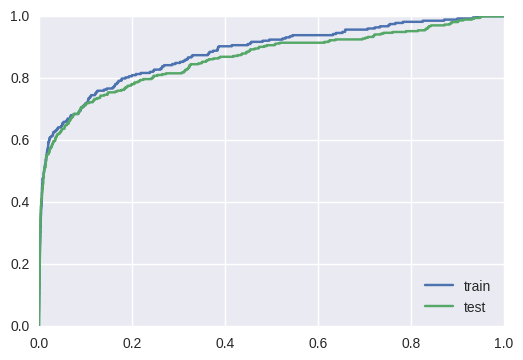

time: 912 ms


In [176]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
train_preds, val_preds = res
y_train = train_preds[:, 0]
y_train_pred = train_preds[:, 1]

y_test_full = test_preds[:, 0]
y_test_pred_full = test_preds[:, 1]
y_test = y_test_full[np.where(y_test_full >= 0)]
y_test_pred = y_test_pred_full[np.where(y_test_full >= 0)]


pr_result(y_train, y_test, y_train_pred, y_test_pred)
roc_result(y_train, y_test, y_train_pred, y_test_pred)

In [168]:
train_preds

[]

time: 4.65 ms


In [90]:
def load_hdfs_vector(hdfsPath, tmpPath="/tmp/", shape=None):
    status = list(hdfsclient.copyToLocal([hdfsPath], tmpPath))[0]
    fname = os.path.basename(os.path.normpath(hdfsPath))
    print status['error']
    vectors = []
    if status['error'] != '':
        return 
    
    for part in os.listdir(tmpPath + fname):
        partName = tmpPath + fname + "/" + part
        if (os.stat(partName).st_size == 0):
            continue
        part_vector = np.ravel(genfromtxt(partName, delimiter=","))
        vectors.append(part_vector)
        
    ov = np.concatenate(vectors)
    if (shape != None):
        ov = ov.reshape(shape)
        
    os.system("rm -rf " + tmpPath + fname)
    return ov
        
            

time: 25.1 ms


In [94]:
v = load_hdfs_vector("/user/vaishaal/tmp/testPreds_chr11_8/", shape=(-1, 2))


time: 1.82 s


In [95]:
v.shape

(2645, 2)

time: 4.1 ms


In [65]:
list(hdfsclient.copyToLocal(["/user/vaishaal/tmp/testPreds_chr11_8/"], "/tmp/vector"))

[{'error': '',
  'path': '/tmp/vector/testPreds_chr11_8',
  'result': True,
  'source_path': '/user/vaishaal/tmp/testPreds_chr11_8'},
 {'error': '',
  'path': '/tmp/vector/testPreds_chr11_8/_SUCCESS',
  'result': True,
  'source_path': '/user/vaishaal/tmp/testPreds_chr11_8/_SUCCESS'},
 {'error': '',
  'path': '/tmp/vector/testPreds_chr11_8/part-00000',
  'result': True,
  'source_path': '/user/vaishaal/tmp/testPreds_chr11_8/part-00000'},
 {'error': '',
  'path': '/tmp/vector/testPreds_chr11_8/part-00001',
  'result': True,
  'source_path': '/user/vaishaal/tmp/testPreds_chr11_8/part-00001'},
 {'error': '',
  'path': '/tmp/vector/testPreds_chr11_8/part-00002',
  'result': True,
  'source_path': '/user/vaishaal/tmp/testPreds_chr11_8/part-00002'},
 {'error': '',
  'path': '/tmp/vector/testPreds_chr11_8/part-00003',
  'result': True,
  'source_path': '/user/vaishaal/tmp/testPreds_chr11_8/part-00003'},
 {'error': '',
  'path': '/tmp/vector/testPreds_chr11_8/part-00004',
  'result': True,
  '

time: 2.03 s


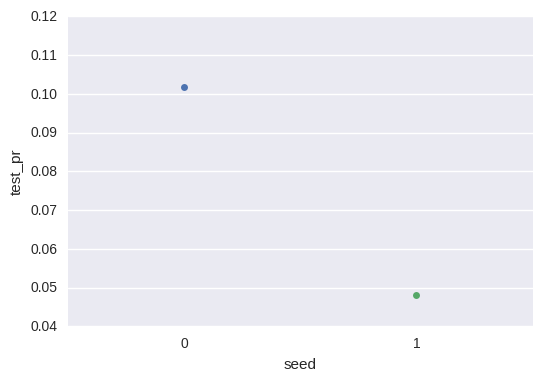

time: 205 ms


In [15]:
sns.stripplot(x='seed', y='test_pr', data=df)

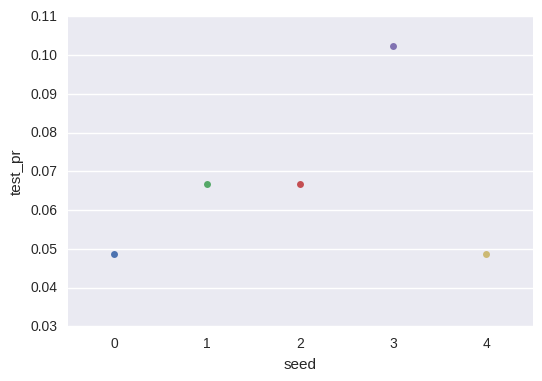

In [43]:
sns.stripplot(x='seed', y='test_pr', data=df)

#### PR Metrics

Train PR AUC 0.757754546452
Test PR AUC 0.121105773929


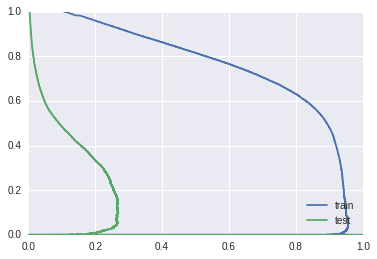

time: 2.96 s
